In [52]:
%run paper/setup.py

In [2]:
from exoplanet.utils import eval_in_model
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano

class SyntheticBinary(object):
    """
    This class makes a synthetic light curve and injects a time delay signal corresponding to the input binary orbit parameters    
    """
    def __init__(self, time, freq, amplitude, 
                 period, eccen, asini, varpi, tref):
        self.time = time
        self.freq = freq
        self.amplitude = amplitude
        self.period, self.eccen, self.asini, self.varpi, self.tref = period, eccen, asini, varpi, tref
        
        self.make_lightcurve()
        self.flux = self.flux_true
        
    def make_lightcurve(self):
        self.flux_true = np.zeros(len(self.time))
        
        with pm.Model() as model:
            #M = tt.zeros_like(tt.constant(self.time) - self.tref) + 2.0 * np.pi * (tt.constant(self.time)) / self.period
            M = 2.0 * np.pi * (tt.constant(self.time) - self.tref) / self.period
            f = get_true_anomaly(M, self.eccen + tt.zeros_like(M))
            tau_tens = ((1 - tt.square(self.eccen)) * tt.sin(f+self.varpi) / (1 + self.eccen*tt.cos(f))) * (self.asini / 86400.)
            self.tau = eval_in_model(tau_tens)
            
        for j, A_j in zip(self.freq, self.amplitude):
            omega = 2 * np.pi * j
            self.flux_true += A_j * np.sin(omega * (self.time - self.tau))# + A_j * np.sin(omega * (self.time - self.tau))
            
    def add_noise(self, snr=5):
        # Add noise
        s_rms = self.amplitude / (np.sqrt(np.pi / len(self.time)) * snr)
        #print(s_rms, self.amplitude)
        #print(np.random.normal(loc=0.0, scale=s_rms, size=len(self.time)))
        self.flux = self.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(self.time))
        #self.flux_err = noise * np.std(self.flux_true)
        #self.flux = self.flux_true + self.flux_err * np.random.randn(len(self.flux_true))

In [3]:
snrs = np.geomspace(1,1000,51)
eccens = [0.,0.8,0.95,0.99]

# Fixed parameters
period_t = 10
asini_t = 100
varpi_t = 0.
tref_t = 0.
freqs = np.array([50])
amps = np.array([0.1])
eccen_t = 0.9

time = np.arange(0, 3*period_t, 1.0 / (24 * 30))

In [4]:

lc = SyntheticBinary(time, freqs, amps, period_t, eccen_t, asini_t, varpi_t, tref_t)
lc.add_noise(snr=50)

# ms = Maelstrom(lc.time, lc.flux, freq=freqs)
# a, b = ms.get_time_delay(segment_size=2.)
# a += ms.time_mid

time_tensor = theano.shared(lc.time)
flux_tensor = theano.shared(lc.flux)

# td_time_tensor = theano.shared(a)
# td_td_tensor = theano.shared(b[:,0])

with pm.Model() as fit_model:
    period = pm.Flat("period", testval=9)#pm.Uniform("period", lower=1, upper=100, testval=period_t)
    asini = pm.Flat("asini", testval=asini_t)#asini_t#pm.Uniform("asini", lower=0, upper=1000, testval=asini_t)
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux_tensor.get_value())), sd=10, testval=0.)
    eccen = pm.Flat('eccen', testval=eccen_t)#pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=eccen_t)
    omega, phi = 0., 0.
    
    M = 2.0 * np.pi * time_tensor / period - phi
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    psi = (1 - tt.square(eccen)) * tt.sin(f+omega) / (1 + eccen*tt.cos(f))

    # Positive
    arg = 2. * np.pi * freqs * (time_tensor[:, None] - ((asini) / 86400) * psi[:, None])
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    DT = D.T
    w = tt.slinalg.solve(tt.dot(DT, D), tt.dot(DT, flux_tensor))
    lc_model = tt.dot(D, w)

    pm.Normal('obs', mu=lc_model, 
              sd=tt.exp(logs_lc), 
              observed=flux_tensor)
    
    fit_params = [v for v in fit_model.vars if v.name not in ["period", "eccen"]]
    
# with pm.Model() as subdivide_model:
#     period = pm.Flat("period", testval=period_t)#pm.Uniform("period", lower=1, upper=100, testval=period_t)
#     asini = pm.Flat("asini", testval=asini_t)#asini_t#pm.Uniform("asini", lower=0, upper=1000, testval=asini_t)
#     logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux_tensor.get_value())), sd=10, testval=0.)
#     eccen = pm.Flat('eccen', testval=eccen_t)#pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=eccen_t)
#     omega, phi = 0., 0.
    
#     M = 2.0 * np.pi * td_time_tensor / period - phi
#     f = get_true_anomaly(M, eccen + tt.zeros_like(M))
#     psi = (1 - tt.square(eccen)) * tt.sin(f+omega) / (1 + eccen*tt.cos(f))

#     tau = (asini) * psi

#     pm.Normal('obs', mu=tau, 
#               sd=tt.exp(logs_lc), 
#               observed=td_td_tensor)
    
#     fit_params_subdivide = [v for v in subdivide_model.vars if v.name not in ["period", "eccen"]]

In [5]:
def run_fit(time, flux, period, asini, eccen):
    with fit_model:
        time_tensor.set_value(time)
        flux_tensor.set_value(flux)
        
        start = dict(fit_model.test_point)
        start['period'] = period
        start['asini'] = asini
        start['eccen'] = eccen
        
        return xo.optimize(start, vars=fit_params, verbose=False)
    
# def run_fit_subdivide(td_time, td_td, period, asini, eccen):
#     with subdivide_model:
#         td_time_tensor.set_value(td_time)
#         td_td_tensor.set_value(td_td)
        
#         start = dict(subdivide_model.test_point)
#         start['period'] = period
#         start['asini'] = asini
#         start['eccen'] = eccen
        
#         return xo.optimize(start, vars=fit_params_subdivide, verbose=False)

In [6]:
lc = SyntheticBinary(time, freqs, amps, period_t, eccen_t, asini_t, varpi_t, tref_t)
lc.add_noise(snr=50000)

opt = run_fit(lc.time, lc.flux, period_t, asini_t, eccen_t)
# opt_subd = run_fit_subdivide(a, b[:,0], period_t, asini_t, eccen_t)

In [7]:
opt

{'period': array(10.),
 'asini': array(100.00382711),
 'logs_lc': array(-8.70217056),
 'eccen': array(0.9)}

In [20]:
from tqdm import tqdm
snr=5
eccen_t = 0.5
lc = SyntheticBinary(time, freqs, amps,
     period_t, eccen_t, asini_t, varpi_t, tref_t)
s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
asini_x = []
for i in tqdm(range(100)):
    noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))
    # Run the fit
    opt = run_fit(lc.time, noisy_flux, period_t, asini_t, eccen_t)
    asini_x.append(opt['asini'])

100%|██████████| 100/100 [02:39<00:00,  2.14s/it]


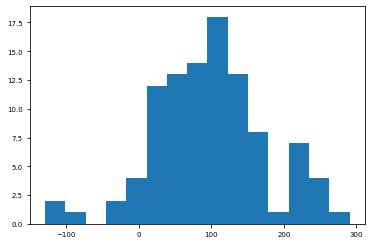

In [21]:
plt.hist(asini_x, bins=15);

In [22]:
np.median(asini_x)

95.4963459709348

## FITTING

In [21]:
snrs = np.geomspace(1,1000,51)
# eccens = [0.,0.8,0.99]
eccens = [0.,0.5,0.99]

In [22]:
from tqdm import tqdm

asinis_all_maelstrom = []
uncertainties_all_maelstrom = []

for eccen in eccens:
    eccen_t = eccen
    lc = SyntheticBinary(time, freqs, amps,
         period_t, eccen_t, asini_t, varpi_t, tref_t)
    
    uncertainties = []
    asinis = []
    # Iterate over each SNR for the given eccentricity
    for snr in tqdm(snrs):
        s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
        asini_x = []
#         for i in range(100):
        noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))
        # Run the fit
        opt = run_fit(lc.time, noisy_flux, period_t, asini_t, eccen_t)
#         asini_x.append(opt['asini'])
        asinis.append(opt['asini'])
        
#         # Get Hessian estimate
#         with fit_model:
#             hess = pm.find_hessian(opt, vars=[asini])
#         uncertainties.append(1/np.sqrt(np.abs(np.diag(hess)))[0])
    asinis_all_maelstrom.append(asinis)
#     uncertainties_all_maelstrom.append(uncertainties)

asinis_all_maelstrom = np.array(asinis_all_maelstrom)
#uncertainties_all_maelstrom = np.array(uncertainties_all)

100%|██████████| 51/51 [1:47:17<00:00, 110.70s/it]


In [24]:
np.savetxt('asinis_all_maelstrom_MC.txt', asinis_all_maelstrom)

In [26]:
asinis_all_maelstrom

array([[ 135.37044363,  146.35233632,  108.06020408,   96.81153293,
         123.71740283,   97.19749082,  108.90462941,   80.77251534,
          88.12216521,   99.28151694,   87.44952671,   98.42133651,
         110.39061827,   97.72219699,   96.26168857,   99.97522124,
         105.14760244,   98.72569468,  105.62302801,   96.91374335,
         100.10198032,   99.27292169,  101.71528456,   99.88988249,
          98.00946982,  100.17381646,  101.59769488,  100.64318019,
          97.74426243,  100.47756712,  100.34844773,  100.38016596,
          99.44822428,   99.82619088,  100.58372382,  100.42608347,
         100.22595105,  100.17812365,   99.95932505,   99.7179282 ,
         100.17803974,  100.18391897,  100.01124416,  100.19031176,
          99.92884234,  100.19633071,   99.9871821 ,   99.85459566,
          99.94983796,  100.07524942,   99.99477676],
       [ 134.87118919,   70.15778836,   57.76416733,  110.95904926,
         140.57981032,  126.48018046,   50.13773843,  110.1692

Text(0, 0.5, 'Fractional a$\\sin{i}$ uncertainty')

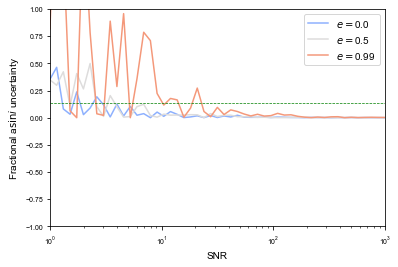

In [32]:
#plt.figure(figsize=mnras_size(240.))
asinis_all_maelstrom = np.array(asinis_all_maelstrom)

from maelstrom.utils import unique_colors
colors = unique_colors(len(eccens), cmap='coolwarm')#[::-1]

for unc, ecc, col in zip(asinis_all_maelstrom, eccens, colors):
    plt.plot(snrs, np.abs((100- unc)/ 100.), label=r'$e=$' + str(ecc), c=col)

plt.axhline(0.136, c='green', linestyle='dashed', linewidth=0.7)

plt.xscale('log')
plt.ylim(-1,1)
plt.xlim(1,1000)

plt.legend()
# plt.text(0.5, 0.5, 'Some Text', ha='center', va='center',rotation='vertical', backgroundcolor='white')

plt.xlabel('SNR')
plt.ylabel(r'Fractional a$\sin{i}$ uncertainty')

In [33]:
# # Fixed parameters
# period_t = 10
# asini_t = 100
# varpi_t = 0.
# tref_t = 0.
# freqs = np.array([50])
# amps = np.array([0.1])
# eccen_t = 0.9
# time = np.arange(0, 27, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs, amps, period_t, eccen_t, asini_t, varpi_t, tref_t)
lc.add_noise(snr=50)

ms = Maelstrom(lc.time, lc.flux, freq=freqs)
a, b = ms.get_time_delay(segment_size=2.)
a += ms.time_mid

td_time_tensor = theano.shared(a)
td_td_tensor = theano.shared(b[:,0])

with pm.Model() as subdivide_model:
    period = pm.Flat("period", testval=period_t)#pm.Uniform("period", lower=1, upper=100, testval=period_t)
    asini = pm.Flat("asini", testval=asini_t)#asini_t#pm.Uniform("asini", lower=0, upper=1000, testval=asini_t)
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux_tensor.get_value())), sd=10, testval=0.)
    eccen = pm.Flat('eccen', testval=eccen_t)#pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=eccen_t)
    omega, phi = 0., 0.
    
    M = 2.0 * np.pi * td_time_tensor / period - phi
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    psi = (1 - tt.square(eccen)) * tt.sin(f+omega) / (1 + eccen*tt.cos(f))

    tau = (asini) * psi

    pm.Normal('obs', mu=tau, 
              sd=tt.exp(logs_lc), 
              observed=td_td_tensor)
    
    fit_params_subdivide = [v for v in subdivide_model.vars if v.name not in ["period", "eccen"]]

In [14]:
def run_fit_subdivide(td_time, td_td, period, asini, eccen):
    with subdivide_model:
        td_time_tensor.set_value(td_time)
        td_td_tensor.set_value(td_td)
        
        start = dict(subdivide_model.test_point)
        start['period'] = period
        start['asini'] = asini
        start['eccen'] = eccen
        
        return xo.optimize(start, vars=fit_params_subdivide, verbose=False)

In [15]:
from tqdm import tqdm

asinis_all_subdivide = []
uncertainties_all_subdivide = []

for eccen in eccens:
    eccen_t = eccen
    lc = SyntheticBinary(time, freqs, amps,
         period_t, eccen_t, asini_t, varpi_t, tref_t)
    
    uncertainties = []
    asinis = []
    # Iterate over each SNR for the given eccentricity
    for snr in tqdm(snrs):
        s_rms = lc.amplitude / (np.sqrt(np.pi / len(lc.time)) * snr)
        np.random.seed(42)
        noisy_flux = lc.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(lc.time))
        # Run the fit
        ms = Maelstrom(lc.time, noisy_flux, freq=freqs)
        a, b = ms.get_time_delay(segment_size=2.)
        a += ms.time_mid

        opt = run_fit_subdivide(a, b[:,0], period_t, asini_t, eccen_t)
        asinis.append(opt['asini'])
        
        # Get Hessian estimate
#         with subdivide_model:
#             hess = pm.find_hessian(opt, vars=[asini])
#         uncertainties.append(1/np.sqrt(np.abs(np.diag(hess)))[0])
    asinis_all_subdivide.append(asinis)
#     uncertainties_all_subdivide.append(uncertainties)

asinis_all_subdivide = np.array(asinis_all_subdivide)
# uncertainties_all_subdivide = np.array(uncertainties_all_subdivide)

100%|██████████| 51/51 [00:28<00:00,  2.26it/s]


In [18]:
np.savetxt('paper/data/asinis_all_subdivide_10d', asinis_all_subdivide)

In [53]:
asinis_all_subdivide10d = np.loadtxt('paper/data/asinis_all_subdivide_10d')
asinis_all_subdivide100d = np.loadtxt('paper/data/asinis_all_subdivide_100d')
asinis_all_maelstrom10d = np.loadtxt('paper/data/asinis_all_maelstrom_10d')
asinis_all_maelstrom100d = np.loadtxt('paper/data/asinis_all_maelstrom_100d')

# asinis_all_subdivide10d = asinis_all_subdivide10d[:1] + asinis_all_subdivide10d[1:]
# asinis_all_subdivide100d = asinis_all_subdivide100d[:1] + asinis_all_subdivide100d[1:]
# asinis_all_maelstrom10d = asinis_all_maelstrom10d[:1] + asinis_all_maelstrom10d[1:]
# asinis_all_maelstrom100d = asinis_all_maelstrom100d[:1] + asinis_all_maelstrom100d[1:]

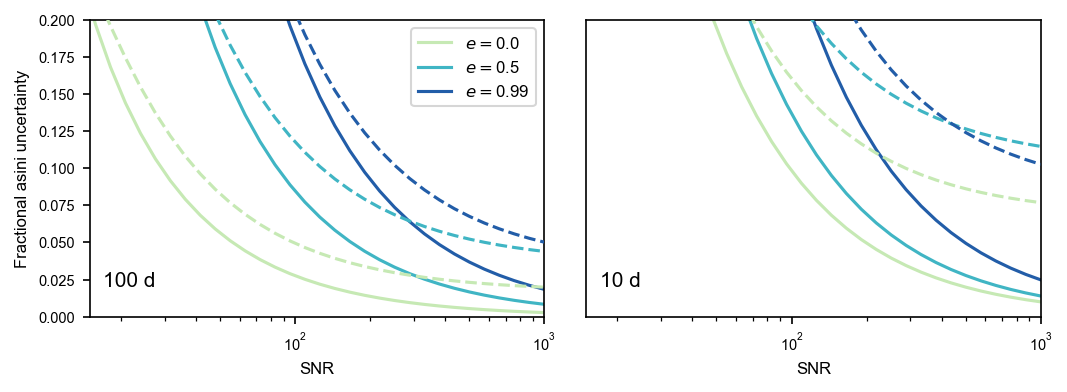

In [55]:
#plt.figure(figsize=mnras_size(240.))
from maelstrom.utils import unique_colors
colors = unique_colors(3, cmap='YlGnBu')

fig, axes = plt.subplots(1,2, figsize=[7,2.5], constrained_layout=True)

ax = axes[0]
for asini_subd, asini_mael, color, eccen in zip(asinis_all_subdivide100d, asinis_all_maelstrom100d, colors, eccens):
    ax.plot(snrs, (100 - asini_subd) / 100, c=color, linestyle='dashed', zorder=5)
    ax.plot(snrs, (100 - asini_mael) / 100, c=color, label=r'$e=$' + str(eccen), zorder=1)
    
ax = axes[1]
for asini_subd, asini_mael, color, eccen in zip(asinis_all_subdivide10d, asinis_all_maelstrom10d, colors, eccens):
    ax.plot(snrs, (100 - asini_subd) / 100, c=color, linestyle='dashed', zorder=5)
    ax.plot(snrs, (100 - asini_mael) / 100, c=color, label=r'$e=$' + str(eccen), zorder=1)
    
axes[0].set_xlim(15,1000)
axes[0].set_ylim(0,0.2)
axes[1].set_xlim(15,1000)
axes[1].set_ylim(0,0.2)

axes[1].set_yticks([])
axes[0].legend(loc=0)

axes[0].set_xscale('log')
axes[1].set_xscale('log')

axes[0].set_xlabel('SNR')
axes[1].set_xlabel('SNR')

axes[0].set_ylabel('Fractional asini uncertainty')

axes[0].text(17,0.02, '100 d', fontsize=10)
axes[1].text(17,0.02, '10 d', fontsize=10)

plt.savefig(overleaf_path + 'comparison.pdf', dpi=300, bbox_inches='tight', pad_inches=0.)